# Import Libraries

In [1]:
from os import path

import pandas as pd


from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix

from kneed import KneeLocator

import matplotlib.pyplot as plt
import seaborn as sns

# Load Datasets

In [2]:
df_pca = pd.read_csv(path.join("..", "data", "heart_disease_pca.csv"))
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,num
0,-1.087992,0.372638,1.271275,-0.240135,0.576431,0.856537,0.603891,-0.614801,-0.541453,0.245773,0.736680,0.686322,-0.640268,0.368900,0
1,-2.813771,0.807979,-0.120024,-0.558623,-0.570164,-0.825947,0.571407,0.003537,-0.490289,0.185441,0.161555,-0.754878,-0.485284,-0.437692,2
2,-2.329030,-1.089585,-0.474496,-0.027767,0.031975,1.028541,0.443364,0.631092,0.359245,0.250978,0.287731,0.055109,0.039899,0.056094,1
3,1.163143,-0.662409,1.579279,2.340236,1.617635,0.380933,-0.506575,-0.384098,-0.565434,-0.351726,0.162886,-0.532354,-0.092187,-0.393656,0
4,1.749042,-0.197127,0.929031,0.555730,0.824813,-0.459967,0.946655,0.539861,-0.350032,0.043926,-0.498762,0.214697,0.208312,0.900747,0


In [3]:
df_selected = pd.read_csv(path.join("..", "data", "heart_disease_selected_features.csv"))
df_selected.head()

,age,cp_asymptomatic,trestbps,chol,thalach,exang_yes,oldpeak,slope_upsloping,slope_flat,ca_0,ca_2,ca_3,thal_normal,thal_reversible_defect,num
0,0.936181,0.0,0.750380,-0.276443,0.017494,0.0,1.068965,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,1.378929,1.0,1.596266,0.744555,-1.816334,1.0,0.381773,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2
2,1.378929,1.0,-0.659431,-0.353500,-0.899420,1.0,1.326662,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1
3,-1.941680,0.0,-0.095506,0.051047,1.633010,0.0,2.099753,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,-1.498933,0.0,-0.095506,-0.835103,0.978071,0.0,0.295874,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0


# Separate Features and Target

In [4]:
X_pca = df_pca.drop(columns=["num"])
X_selected = df_selected.drop(columns=["num"])
y = df_selected["num"]

# Determine K using Elbow Method

We run K-Means clustering on the dataset for a range of K values (e.g., 1 to 10) and calculate the inertia (sum of squared distances to the nearest cluster center) for each K.

We then plot the Within-Cluster Sum of Squares (WSS) or inertia values against K to visualize the "elbow" point, which indicates the optimal number of clusters.

In [5]:
def kmeans_k(X, max_k=10):
    wss = []
    K = range(1, max_k + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wss.append(kmeans.inertia_)

    df = pd.DataFrame({"Clusters": K, "WSS": wss})
    return df


def plot_kmeans_k(df, name):
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x="Clusters", y="WSS", marker="o")
    plt.title(f'Elbow Method ({name})')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WSS)')
    plt.xticks(df["Clusters"])
    plt.grid(True)
    plt.show()


def find_elbow(df):
    kneedle = KneeLocator(df["Clusters"], df["WSS"], curve="convex", direction="decreasing")
    return kneedle.elbow

In [6]:
df_k_pca = kmeans_k(X_pca, max_k=10)
df_k_pca

,Clusters,WSS
0,1,2537.865928
1,2,2072.131327
2,3,1949.384574
3,4,1782.427609
4,5,1705.106335
5,6,1649.005840
6,7,1609.021004
7,8,1541.476040
8,9,1487.678535
9,10,1460.854185


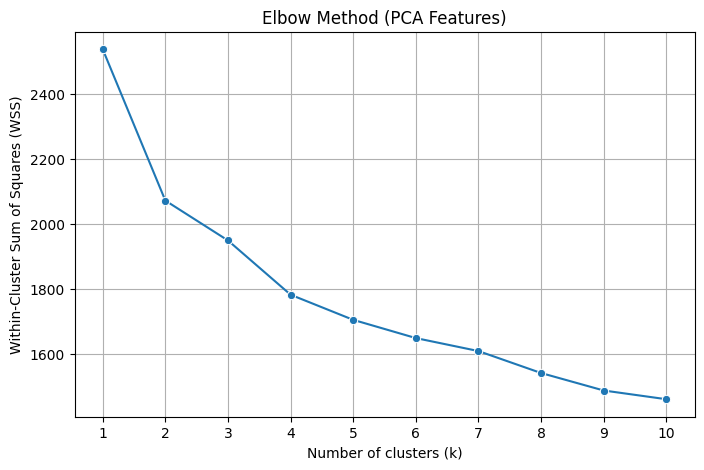

In [7]:
plot_kmeans_k(df_k_pca, "PCA Features")

In [8]:
elbow_pca = find_elbow(df_k_pca)
print(f'Optimal number of clusters (PCA Features): {elbow_pca}')

Optimal number of clusters (PCA Features): 4


In [9]:
df_k_selected = kmeans_k(X_selected, max_k=10)
df_k_selected

,Clusters,WSS
0,1,2039.942761
1,2,1601.823191
2,3,1431.094156
3,4,1327.450420
4,5,1270.647220
5,6,1195.842613
6,7,1133.348995
7,8,1094.324421
8,9,1058.644739
9,10,1011.897058


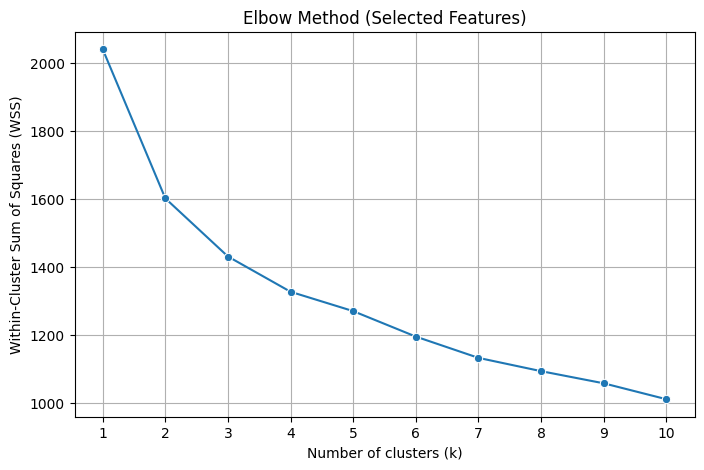

In [10]:
plot_kmeans_k(df_k_selected, "Selected Features")

In [11]:
elbow_selected = find_elbow(df_k_selected)
print(f'Optimal number of clusters (Selected Features): {elbow_selected}')

Optimal number of clusters (Selected Features): 3


# Apply K-Means Clustering with Optimal K

In [12]:
def plot_clusters_2d(X, labels, centroids, name):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker='x', c='r', linewidths=3)
    plt.title(f'K-Means Clustering ({name})')
    plt.xlabel('Feature 1' if "PCA" not in name else "PC 1")
    plt.ylabel('Feature 2' if "PCA" not in name else "PC 2")
    plt.show()

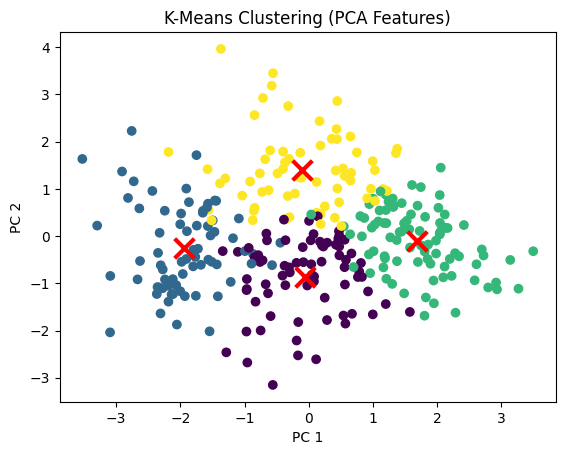

In [13]:
kmeans_pca = KMeans(n_clusters=elbow_pca, random_state=42)
kmeans_pca.fit(X_pca)
labels_pca = kmeans_pca.labels_
centroids_pca = kmeans_pca.cluster_centers_

plot_clusters_2d(X_pca.values, labels_pca, centroids_pca, "PCA Features")

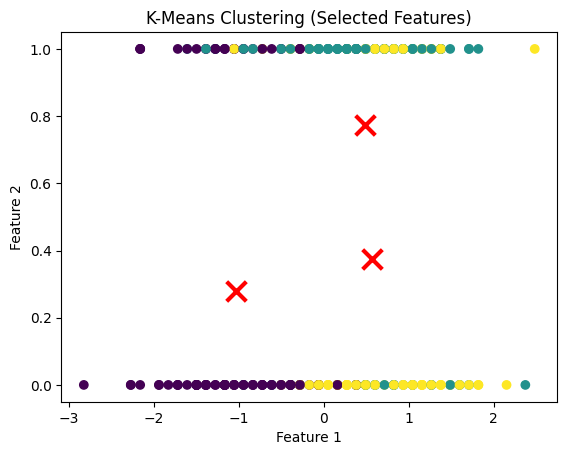

In [14]:
kmeans_selected = KMeans(n_clusters=elbow_selected, random_state=42)
kmeans_selected.fit(X_selected)
labels_selected = kmeans_selected.labels_
centroids_selected = kmeans_selected.cluster_centers_

plot_clusters_2d(X_selected.values, labels_selected, centroids_selected, "Selected Features")

Because of this dimensionality reduction in the plot, the cluster centroids may not appear in the middle of the visible groups. This is expected, since centroids are computed as the mean across all features, not just the first two.

Apply PCA to selected features for better visualization.

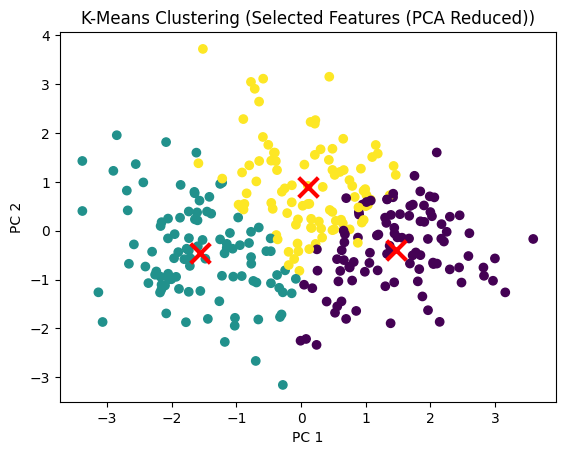

In [15]:
pca_selected = PCA(n_components=2, random_state=42)
X_selected_2d = pca_selected.fit_transform(X_selected.values)

plot_clusters_2d(X_selected_2d, labels_selected, pca_selected.transform(centroids_selected), "Selected Features (PCA Reduced)")

Apply Hierarchical Clustering

In [16]:
def plot_dendrogram(linked, name):
    plt.figure(figsize=(10, 7))
    # truncate_mode='lastp' to show only the last p merged clusters
    dendrogram(linked, truncate_mode='lastp', show_leaf_counts=True)
    plt.title(f'Hierarchical Clustering Dendrogram ({name})')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

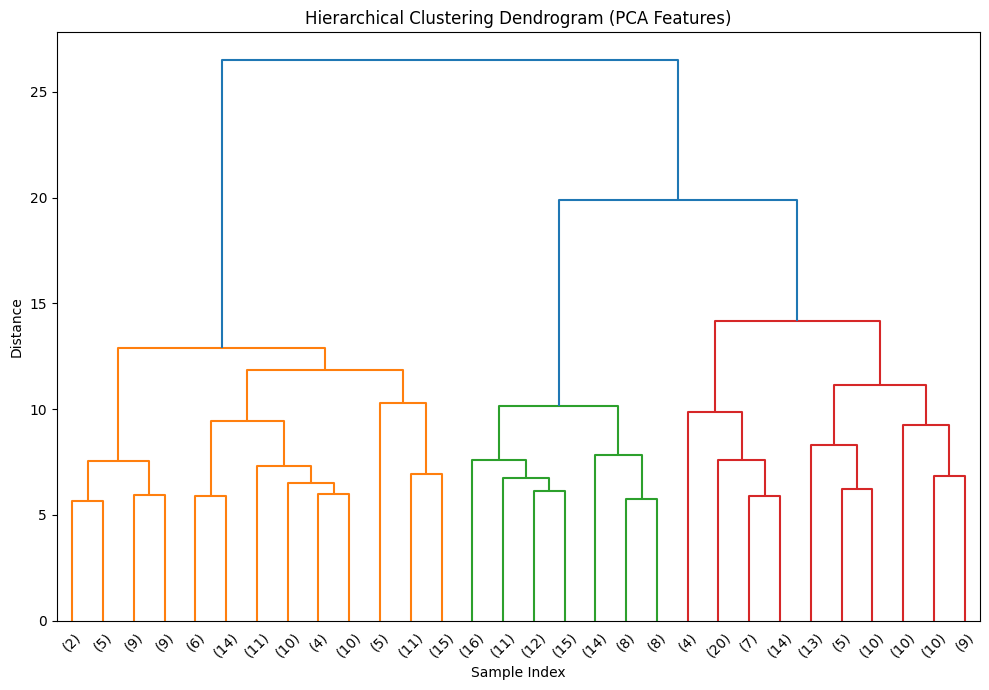

In [17]:
linked_pca = linkage(X_pca, method='ward')
plot_dendrogram(linked_pca, "PCA Features")

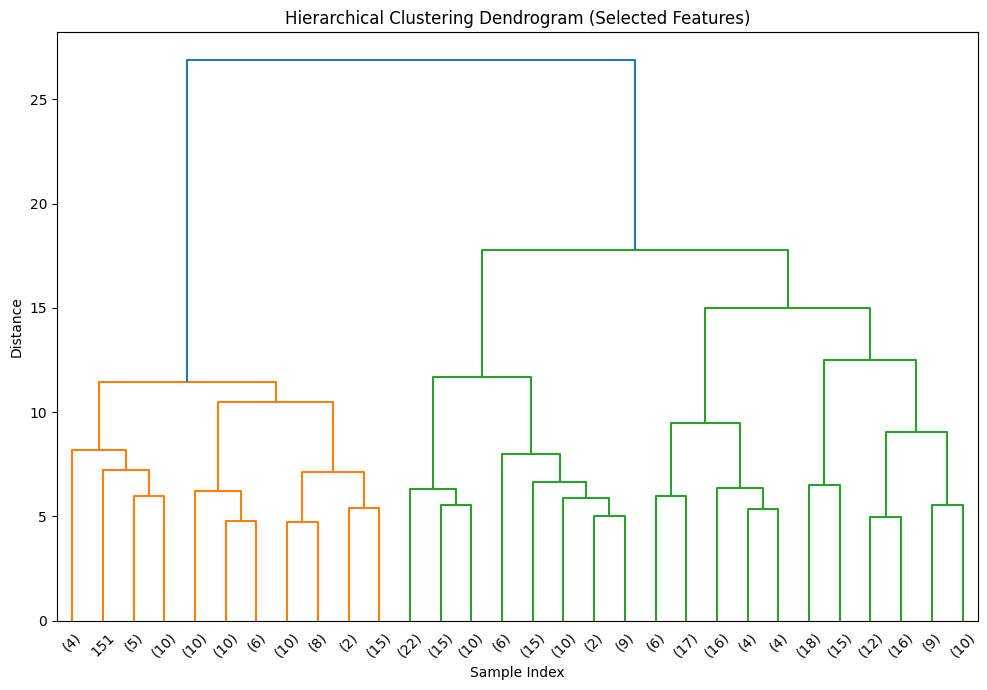

In [18]:
linked_selected = linkage(X_selected, method='ward')
plot_dendrogram(linked_selected, "Selected Features")

# Clusters Evaluation

1. Internal Metrics: Use metrics like Silhouette Score, Davies-Bouldin Index, or Calinski-Harabasz Index to evaluate the cohesion and separation of the clusters formed by K-Means and Hierarchical Clustering.

2. External Metrics: If actual disease labels are available, use metrics like Adjusted Rand Index (ARI), Normalized Mutual Information, or Fowlkes-Mallows Index to compare the clustering results with the true labels.

3. Confusion Matrices: Create a confusion matrix to visualize the performance of the clustering algorithms against the actual labels.

In [19]:
# Form flat clusters using the optimal number of clusters from the elbow method for comparison with K-Means
# 'maxclust' criterion ensures we get exactly that number of clusters
cluster_hier_pca = fcluster(linked_pca, t=elbow_pca, criterion='maxclust')
cluster_hier_selected = fcluster(linked_selected, t=elbow_selected, criterion='maxclust')

In [20]:
ari_kmeans_pca = adjusted_rand_score(y, labels_pca)
ari_hier_pca = adjusted_rand_score(y, cluster_hier_pca)
ari_kmeans_selected = adjusted_rand_score(y, labels_selected)
ari_hier_selected = adjusted_rand_score(y, cluster_hier_selected)

In [21]:
silhouette_pca_kmeans = silhouette_score(X_pca, labels_pca)
silhouette_pca_hier = silhouette_score(X_pca, cluster_hier_pca)
silhouette_selected_kmeans = silhouette_score(X_selected, labels_selected)
silhouette_selected_hier = silhouette_score(X_selected, cluster_hier_selected)

In [22]:
results = pd.DataFrame({
    "Method": ["K-Means (PCA)", "Hierarchical (PCA)", "K-Means (Selected)", "Hierarchical (Selected)"],
    "ARI": [ari_kmeans_pca, ari_hier_pca, ari_kmeans_selected, ari_hier_selected],
    "Silhouette Score": [silhouette_pca_kmeans, silhouette_pca_hier, silhouette_selected_kmeans, silhouette_selected_hier]
})
results

,Method,ARI,Silhouette Score
0,K-Means (PCA),0.152557,0.110944
1,Hierarchical (PCA),0.057683,0.092917
2,K-Means (Selected),0.145678,0.147229
3,Hierarchical (Selected),0.158275,0.108333


In [23]:
results.sort_values(by=["ARI", "Silhouette Score"], ascending=False, inplace=True)
results

,Method,ARI,Silhouette Score
3,Hierarchical (Selected),0.158275,0.108333
0,K-Means (PCA),0.152557,0.110944
2,K-Means (Selected),0.145678,0.147229
1,Hierarchical (PCA),0.057683,0.092917


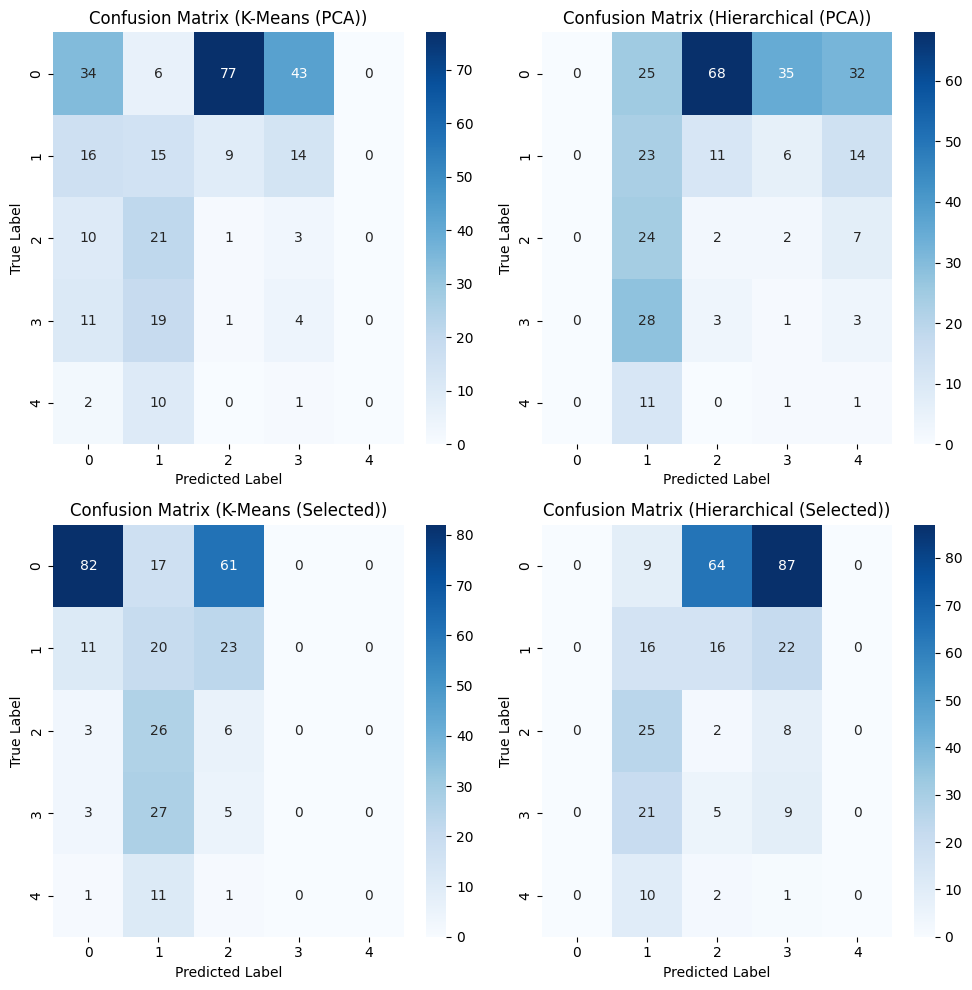

In [24]:
# Confusion Matrix for all models using subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
methods = ["K-Means (PCA)", "Hierarchical (PCA)", "K-Means (Selected)", "Hierarchical (Selected)"]
labels_list = [labels_pca, cluster_hier_pca, labels_selected, cluster_hier_selected]
# zip to iterate over axes, methods, and labels_list simultaneously
for ax, method, labels in zip(axes.flatten(), methods, labels_list):
    cm = confusion_matrix(y, labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix ({method})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

In [25]:
# save the results in a text file
with open(path.join("..", "results", "unsupervised_models_evaluation.txt"), "w") as f:
    f.write("Unsupervised Baseline Models Evaluation Results (Sorted descending based on ARI and Silhouette Score respectively)\n\n")
    f.write(results.to_string(index=False))
    f.write("\n")

The best PCA model: K-Means with k=4

The best Selected Features model: Hierarchical Clustering with 3 clusters